### Description

This file analyzes the outputs from the ML approaches and generates plots for the paper.

### Inputs

In [28]:
# =========================================
# For accessing directories
# =========================================
root_dir = "/local/data/artemis/workspace/jfs2167/recon_eval" # Set this to the path of the project

data_output_dir = f"{root_dir}/data/processed"
reference_output_dir = f"{root_dir}/references"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"
model_output_dir = f"{root_dir}/models/trained"

### Modules

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import skill_metrics as sm
from collections import defaultdict
import pickle
import joblib
from keras.models import load_model

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
from plotting_tools.plotting_tools.spatial_map import SpatialMap

import pre

Using TensorFlow backend.


### Predefined values

In [3]:
# Loading references
path_LET = f"{reference_output_dir}/members_LET_dict.pickle"

with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [26]:
# =========================================
# List of approaches
# =========================================
approaches = ["nn", "xg", "rf"]
approaches_labs = ["NN", "XGB", "RF"]
approaches_colors = ['#1f78b4', '#33a02c', '#e31a1c']

# =========================================
# NN reference for selecting correct run to use
# =========================================
val_df_fname = f"{other_output_dir}/nn/nn_val_performance_df.pickle"
nn_val_df = pd.read_pickle(val_df_fname)

# =========================================
# Feature list
# =========================================
features_sel = ['sst_detrend', 'sst_anom', 'sss', 'sss_anom', 'mld_clim_log', 'chl_log', 'chl_anom', 'xco2', 'A', 'B', 'C', 'T0', 'T1']
target_sel = ['pCO2']

### Import data

In [5]:
# Test and unseen data metrics
df_dict = defaultdict(dict)
for approach in approaches:
    for data in ["test","unseen"]:
        fname = f"{other_output_dir}/{approach}/{approach}_{data}_performance_df.pickle"
        df_dict[approach][data] = pd.read_pickle(fname)

df_dict["nn"]["test"] = df_dict["nn"]["test"]\
                            .loc[df_dict["nn"]["test"].sel_min_bias_mse==1]\
                            .drop(["sel_min_bias","sel_min_mse","sel_min_bias_mse"], axis=1)\
                            .droplevel("run")
df_dict["nn"]["unseen"] = df_dict["nn"]["unseen"]\
                            .loc[df_dict["nn"]["unseen"]\
                            .sel_min_bias_mse==1]\
                            .drop(["sel_min_bias","sel_min_mse","sel_min_bias_mse"], axis=1)\
                            .droplevel("run")

for method in df_dict:
    for data in df_dict[method]:
        new_index = pd.MultiIndex.from_arrays(
                        [[method]*len(df_dict[method][data]),[data]*len(df_dict[method][data])]
                        , names=["approach","data"])
        df_dict[method][data].set_index(new_index, append=True, inplace=True)

In [6]:
# Temporal deconstruction metrics
temporal_fname = f"{other_output_dir}/all_temporal_deconstruction_metrics_df.pickle"
temporal_df = pd.read_pickle(temporal_fname)

In [7]:
# Combining data
df_all = pd.concat([df_dict[method][data] for data in df_dict[method] for method in df_dict] + [temporal_df])
df_all['stdev_%error'] = df_all.apply(lambda row: abs(row.stdev - row.stdev_ref)/row.stdev_ref*100, axis=1)

# Making sure we look at the 100 members in the LET
mask = df_all.apply(lambda row: row.name[1] in mems_dict[row.name[0]], axis=1)
df_all = df_all.loc[mask]

In [8]:
# Pulling in map metrics
map_data_fname = f"{other_output_dir}/map_data_approach.pickle"
map_data_ens_fname = f"{other_output_dir}/map_data_ens.pickle"

with open(map_data_fname,"rb") as handle:
    map_data = pickle.load(handle)

with open(map_data_ens_fname,"rb") as handle:
    map_data_ens = pickle.load(handle)

### RMSE boxplot and RMSE degradation bars - approach granularity (fig01 in paper)

In [9]:
df_all_reset = df_all.copy().reset_index().loc[(df_all.index.get_level_values("data")=="test")|(df_all.index.get_level_values("data")=="unseen")]
df_all_reset['approach+data'] = df_all_reset.apply(lambda row: row.approach.upper() + ", " + row.data + " data", axis=1)
df_all_reset.sort_values('approach+data', inplace=True)
df_all_reset["rmse"] = np.sqrt(df_all_reset["mse"])

In [10]:
degradation_df = df_all_reset \
    .groupby(["approach","data"]) \
    .mean()[["rmse"]] \
    .unstack(1)

degradation_df.columns = degradation_df.columns.get_level_values(1)

degradation_df["increase"] = (degradation_df[("unseen")] / degradation_df["test"] - 1)*100

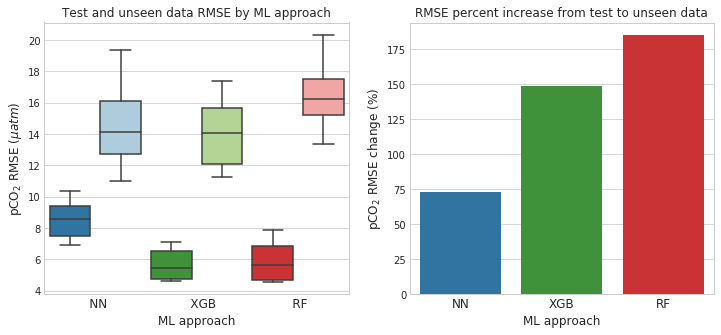

In [11]:


colors = ['#1f78b4','#a6cee3', '#33a02c', '#b2df8a', '#e31a1c', '#fb9a99']
plot_order = ['NN, test data','NN, unseen data','XG, test data','XG, unseen data','RF, test data','RF, unseen data']

with plt.style.context('seaborn-whitegrid'):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    sns.boxplot(data = df_all_reset, x="approach+data", y="rmse", order = plot_order, palette = colors, ax=ax[0])
    ax[0].set_title('Test and unseen data RMSE by ML approach', size="large")
    xlabels = ['     NN','','     XGB','','     RF','']
    ax[0].set_xticklabels(xlabels, horizontalalignment="left", size="large")
    ax[0].set_xlabel('ML approach', size="large")
    ax[0].set_ylabel('pCO$_2$ RMSE ($\mu atm$)', size="large")

    sns.barplot(data = degradation_df.reset_index(), x="approach", y="increase", order = ['nn', 'xg', 'rf'], palette = approaches_colors, ax=ax[1])
    ax[1].set_title('RMSE percent increase from test to unseen data', size="large")
    ax[1].set_xticklabels(approaches_labs, size="large")
    ax[1].set_xlabel('ML approach', size="large")
    ax[1].set_ylabel('pCO$_2$ RMSE change (%)', size="large")

# plt.savefig('fig01.png', dpi=300, bbox_inches = "tight")
# plt.savefig('fig01.eps', dpi=300, bbox_inches = "tight")

### Mean bias map - approach granularity (fig02 in paper)

bias_mean for raw data by ML approach


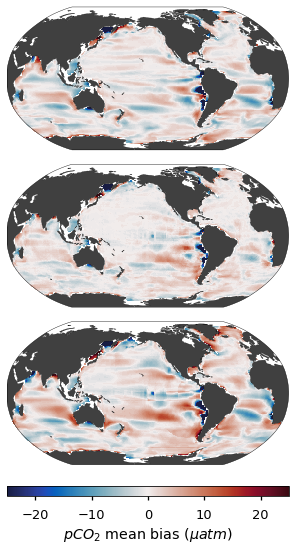

In [12]:
data_sel = "raw"
metric_sel = "bias_mean"
vrange = [-25, 25, 5]
fig_shape = (3,1)
cmap = cm.cm.balance
lab = '$pCO_2$ mean bias ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6.5,9))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approaches[i],data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)

# plt.savefig("fig_02_nolabel.png", dpi=400, bbox_inches="tight", pad_inches=0.5)

### Stdev of bias map - approach granularity (fig03 in paper)

bias_std for raw data by ML approach


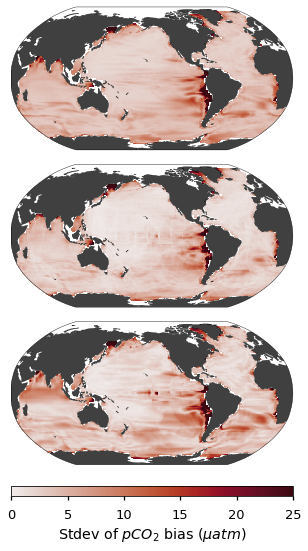

In [13]:
data_sel = "raw"
metric_sel = "bias_std"
vrange = [0, 25, 5]
fig_shape = (3,1)
cmap = cm.cm.amp
lab = 'Stdev of $pCO_2$ bias ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(6.5,9))

    ### Mask
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approaches[i],data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
#         dia.set_title(approaches_labs[i], i, loc="left")
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
# plt.savefig("fig_03_nolabel.png", dpi=400, bbox_inches="tight", pad_inches=0.5)

### Correlation by timescale - approach granularity (fig04 in paper)

corr_mean for ['seasonal', 'resid', 'decadal'] data by ML approach


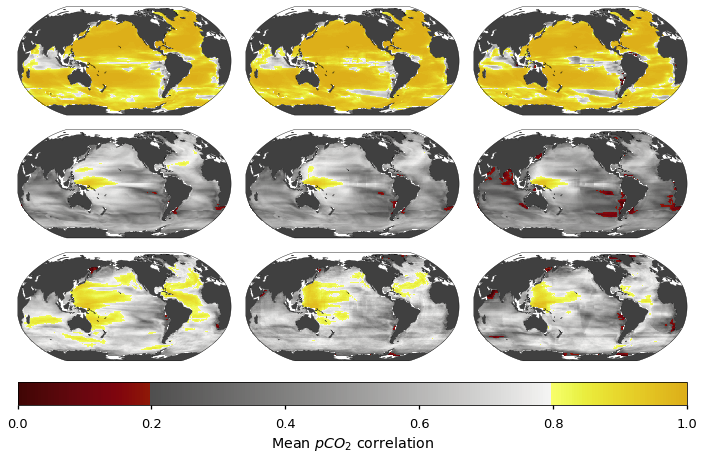

In [14]:
# Correlation by timescale
data_sel = ["seasonal","resid","decadal"]
metric_sel = "corr_mean"
vrange = [0, 1, .01]
fig_shape = (3,3)
cmap = cm.cm.oxy
lab = 'Mean $pCO_2$ correlation'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,12))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approaches[i % 3],data_sel[i // 3],metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
#     dia.set_title("Seasonal - FFN", 0, loc="left")
#     dia.set_title("XGB", 1, loc="center")
#     dia.set_title("RF", 2, loc="center")
#     dia.set_title("Sub-decadal", 3, loc="left", pad=3)
#     dia.set_title("Decadal", 6, loc="left", pad=3)
    
# plt.savefig("fig_04_nolabel.png", dpi=400, bbox_inches="tight", pad_inches=0.5)

### Amplitude % error by timescale - approach granularity (fig05 in paper)

amp_%error for ['seasonal', 'resid', 'decadal'] data by ML approach


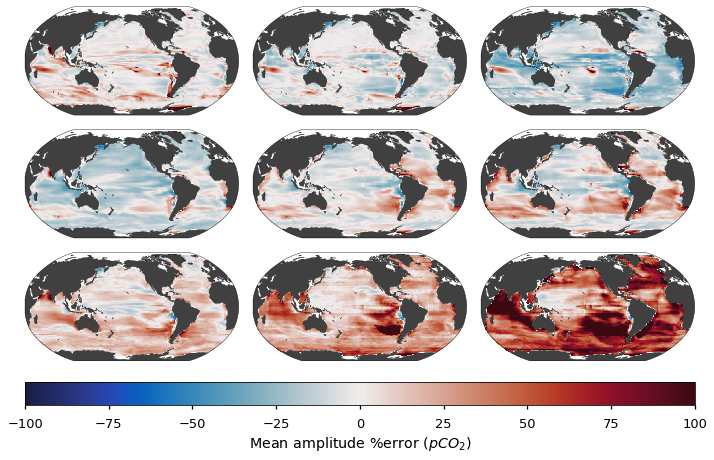

In [15]:
data_sel = ["seasonal","resid","decadal"]
metric_sel = "amp_%error"
vrange = [-100, 100, 1]
fig_shape = (3,len(data_sel))
cmap = cm.cm.balance
lab = 'Mean amplitude %error ($pCO_2$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,12))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approaches[i % 3],data_sel[i // 3],metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T*100, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
#     dia.set_title("Seasonal - FFN", 0, loc="left")
#     dia.set_title("XGB", 1, loc="center")
#     dia.set_title("RF", 2, loc="center")
#     dia.set_title("Sub-decadal", 3, loc="left", pad=3)
#     dia.set_title("Decadal", 6, loc="left", pad=3)
    
# plt.savefig("fig_05_nolabel.png", dpi=400, bbox_inches="tight", pad_inches=0.5)

### Decadal variability actual vs reconstruction - approach granularity (fig06 in paper)

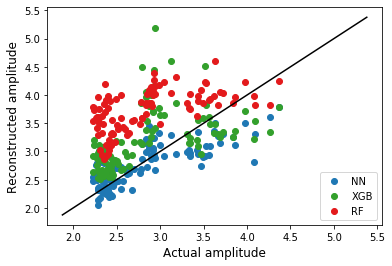

In [16]:
fig, ax = plt.subplots(1,1)

for i in range(3):
    ax.scatter("stdev_ref", "stdev", c=approaches_colors[i]
            ,data=df_all.loc[(df_all.index.get_level_values("data") == "decadal") 
                             & (df_all.index.get_level_values("approach") == approaches[i])])

ax.set_ylabel("Reconstructed amplitude", size="large")
ax.set_xlabel("Actual amplitude", size="large")
ax.legend(["NN", "XGB", "RF"], loc="lower right")
ax.plot(ax.get_ylim(), ax.get_ylim(), color="black")

# plt.savefig('fig06.png', dpi=450, bbox_inches = "tight")

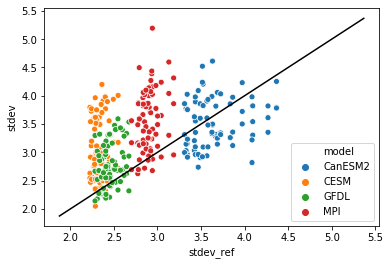

In [17]:
# Not used in paper - same data but colors by ensemble model
fig, ax = plt.subplots(1,1)

sns.scatterplot(x="stdev_ref", y="stdev",
                hue=df_all.loc[df_all.index.get_level_values("data") == "decadal"].index.get_level_values("model"),
                data=df_all.loc[df_all.index.get_level_values("data") == "decadal"], ax=ax)
ax.plot(ax.get_ylim(), ax.get_ylim(), color="black")

### Bias vs sampling scatter - approach granularity (fig07 in paper)

In [18]:
# Using one reconstruction to get the data on months of SOCAT data 
approach = "rf"
ens = "CESM"
member = "001"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
recon_fname_out = f"{recon_dir}/{approach}_recon_temporal_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
DS_recon = xr.load_dataset(recon_fname_out)

88
78
88


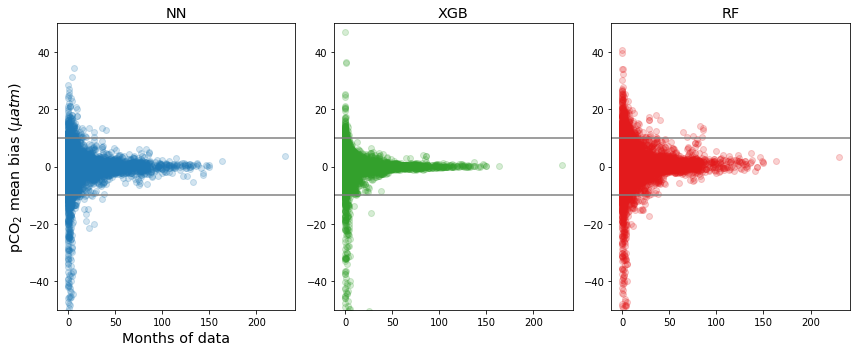

In [19]:
fig, ax = plt.subplots(1,3,figsize=(12,5))

net_sel = ~np.isnan(DS_recon.net_mask[0,:,:].values)
y_range = [-50,50]
z = 10

for i in range(3):
    approach_sel = approaches[i]
    map_data_sel = (approach_sel,"raw","bias_mean")
    data_na_sel = ~np.isnan(map_data[map_data_sel].values)
    overall_sel = net_sel & data_na_sel

    X = DS_recon.socat_mask.sum("time").values[overall_sel]
    y = map_data[map_data_sel].values[overall_sel]

    ax[i].scatter(X,y, c=approaches_colors[i], alpha=0.2)
    if i ==0:
        ax[i].set_xlabel("Months of data", size="x-large");
        ax[i].set_ylabel('pCO$_2$ mean bias ($\mu atm$)', size="x-large");
    ax[i].set_title(approaches_labs[i], size="x-large");
    ax[i].set_ylim(y_range);
    ax[i].axhline(z, color="grey")
    ax[i].axhline(-z, color="grey")
    print(np.sum(y<-50))
    
plt.tight_layout()
# plt.savefig("fig07.png", dpi=400)

In [20]:
88/len(y)

0.0026649707761727385

### Training vs testing RMSE - approach granularity (figA1 in paper)

In [21]:
# Loading dictionary of random seeds
path_seeds = f"{reference_output_dir}/random_seeds.npy"
path_loc = f"{reference_output_dir}/members_seed_loc_dict.pickle"

random_seeds = np.load(path_seeds) 
with open(path_loc,'rb') as handle:
    seed_loc_dict = pickle.load(handle)
    
# Train-validate-test split proportions
val_prop = .2
test_prop = .2

In [ ]:
nn_train_dict = {}
xg_train_dict = {}
rf_train_dict = {}

for ens, mem_list in mems_dict.items():
    for member in mem_list:
        seed_loc = seed_loc_dict[ens][member] # Figure out which column to use for seeds
    
        # Data file path
        data_dir = f"{data_output_dir}/{ens}/member_{member}"
        fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
        file_path = f"{data_dir}/{fname}"
        
        # Read in data, create some selection filters, produce a reduced dataframe
        df = pd.read_pickle(file_path)
        if ens == "CanESM2":
            recon_sel = (~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()
        else:
            recon_sel = ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
        sel = (recon_sel & (df['socat_mask'] == 1))
        unseen_sel = (recon_sel & (df['socat_mask'] == 0))
        
        # Convert dataframe to numpy arrays, train/val/test split
        X = df.loc[sel,features_sel].to_numpy()
        y = df.loc[sel,target_sel].to_numpy().ravel()
                
        N = X.shape[0]
        train_val_idx, train_idx, val_idx, test_idx = pre.train_val_test_split(N, test_prop, val_prop, random_seeds, seed_loc)
        X_train_val, X_train, X_val, X_test, y_train_val, y_train, y_val, y_test = pre.apply_splits(X, y, train_val_idx, train_idx, val_idx, test_idx) 
        
        X_train_s = (X_train - np.mean(X_train,axis=0))/np.std(X_train,axis=0)
        
        for j in approaches:
            if j == "nn":
                i = nn_val_df.loc[ens].loc[member].query("sel_min_bias_mse == 1").index[0]
                fname = f"{model_output_dir}/nn/{ens}/member_{member}/nn_model_pC02_2D_mon_{ens}_{member}_{i}_1x1_198201-201701.h5"
                model = load_model(fname)
                nn_train_dict[(ens,member)] = {"rmse":np.sqrt(model.evaluate(X_train_s, y_train, batch_size=10000000, verbose=0)[1])}
            else:
                fname = f"{model_output_dir}/{j}/{ens}/member_{member}/{j}_model_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.joblib"
                model = joblib.load(fname)
                preds = model.predict(X_train)
            
                if j == "xg":
                    xg_train_dict[(ens,member)] = {"rmse":np.sqrt(((y_train-preds)**2).mean())}
                else:
                    rf_train_dict[(ens,member)] = {"rmse":np.sqrt(((y_train-preds)**2).mean())}

In [58]:
nn_train_df = pd.DataFrame.from_dict(nn_train_dict, orient="index")
nn_train_df.index.names = ["model", "member"]

rf_train_df = pd.DataFrame.from_dict(rf_train_dict, orient="index")
rf_train_df.index.names = ["model", "member"]

xg_train_df = pd.DataFrame.from_dict(xg_train_dict, orient="index")
xg_train_df.index.names = ["model", "member"]

In [59]:
nn_test_df = df_all.loc[(df_all.index.get_level_values("approach")=="nn") 
                        & (df_all.index.get_level_values("data")=="test")].droplevel(["approach","data"])[["mse"]]
nn_all_df = nn_test_df.join(nn_train_df)

nn_all_df.columns = ["mse_test", "rmse_train"]
nn_all_df["rmse_test"] = np.sqrt(nn_all_df["mse_test"])

In [60]:
rf_test_df = df_all.loc[(df_all.index.get_level_values("approach")=="rf") 
                        & (df_all.index.get_level_values("data")=="test")].droplevel(["approach","data"])[["mse"]]
rf_all_df = rf_test_df.join(rf_train_df)

rf_all_df.columns = ["mse_test", "rmse_train"]
rf_all_df["rmse_test"] = np.sqrt(rf_all_df["mse_test"])

In [61]:
xg_test_df = df_all.loc[(df_all.index.get_level_values("approach")=="xg") & (df_all.index.get_level_values("data")=="test")].droplevel(["approach","data"])[["mse"]]
xg_all_df = xg_test_df.join(xg_train_df)

xg_all_df.columns = ["mse_test", "rmse_train"]
xg_all_df["rmse_test"] = np.sqrt(xg_all_df["mse_test"])

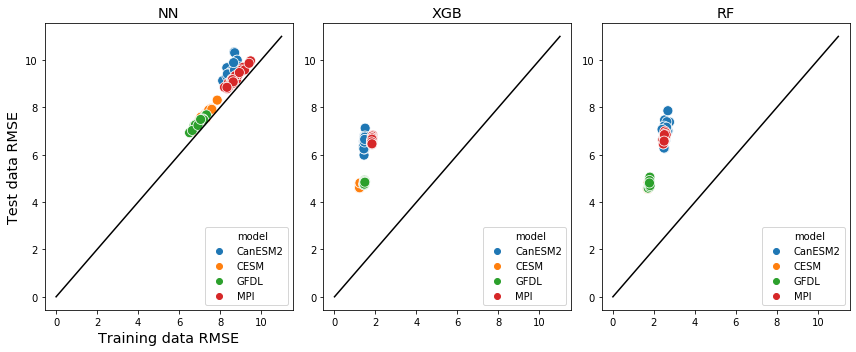

In [93]:
fig, ax = plt.subplots(1,3, figsize=(12,5))
sns.scatterplot(x="rmse_train", y="rmse_test", hue=nn_all_df.index.get_level_values(0), data=nn_all_df, ax=ax[0], s=100)
sns.scatterplot(x="rmse_train", y="rmse_test", hue=xg_all_df.index.get_level_values(0), data=xg_all_df, ax=ax[1], s=100)
sns.scatterplot(x="rmse_train", y="rmse_test", hue=rf_all_df.index.get_level_values(0), data=rf_all_df, ax=ax[2], s=100)
for i in range(3):
    ax[i].plot((0,11), (0,11), color="black")
    ax[i].set_title(approaches_labs[i], size="x-large")
    ax[i].legend(loc="lower right")
    ax[i].set_xlabel("", size="x-large")
    ax[i].set_ylabel("", size="x-large")
    
ax[0].set_xlabel("Training data RMSE", size="x-large")
ax[0].set_ylabel("Test data RMSE", size="x-large")
plt.tight_layout()
# plt.savefig('fig08.png', dpi=450, bbox_inches = "tight")

### Test and unseen RMSE dot plot - approach-ensemble granularity (figA2 in paper)

In [63]:
rmse_df = np.sqrt(df_all \
                  .loc[(df_all.index.get_level_values("data")=="test") \
                       |(df_all.index.get_level_values("data")=="unseen")] \
                  .groupby(["model","approach","data"]).mean()[["mse"]])

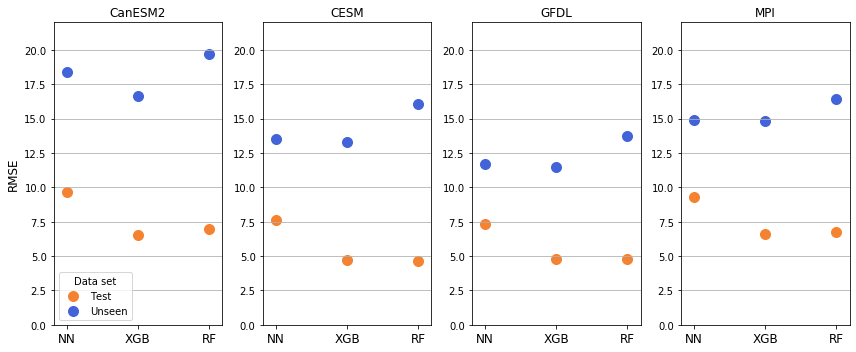

In [94]:
model_list = ["CanESM2", "CESM", "GFDL", "MPI"]
fig,ax = plt.subplots(1,4,figsize=(12,5))

for i in range(4):
    mod_sel = model_list[i]

    plot_data = rmse_df.loc[(rmse_df.index.get_level_values("model")==mod_sel)&(rmse_df.index.get_level_values("data")=="test")].droplevel(0).iloc[[0,2,1]]
    ax[i].scatter(approaches_labs, plot_data, c="#f58231", s=100)

    plot_data = rmse_df.loc[(rmse_df.index.get_level_values("model")==mod_sel)&(rmse_df.index.get_level_values("data")=="unseen")].droplevel(0).iloc[[0,2,1]]
    ax[i].scatter(approaches_labs, plot_data, c="#4363d8", s=100)

    ax[i].set_ylim(0,22)
    ax[i].set_title(mod_sel, size="large")
    ax[i].grid(axis="y")
    ax[i].set_xticklabels(approaches_labs, size="large")

ax[0].legend(["Test", "Unseen"], title="Data set")
ax[0].set_ylabel("RMSE", size="large")


plt.tight_layout()
# plt.savefig('fig09.png', dpi=450, bbox_inches = "tight")

### Mean bias map - approach-ensemble granularity (figA3 in paper)

bias_mean for raw data by ML approach


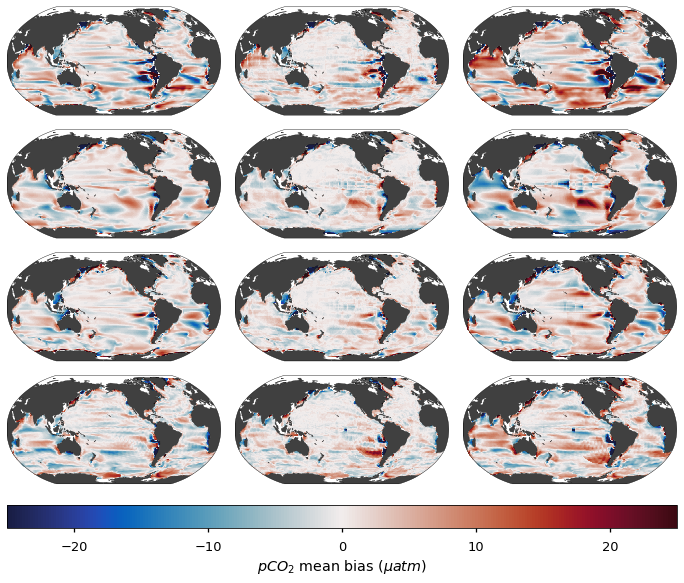

In [95]:
# Bias plot
ens_order = ["CanESM2","CESM","GFDL","MPI"]
data_sel = "raw"
metric_sel = "bias_mean"
vrange = [-25, 25, 5]
fig_shape = (4,3)
cmap = cm.cm.balance
lab = '$pCO_2$ mean bias ($\mu atm$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      

      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,12))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data_ens[(ens_order[i // 3], approaches[i % 3],data_sel,metric_sel)].roll(xlon=-30,roll_coords=True)
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
#     dia.set_title("CanESM2 - NN", 0, loc="left")
#     dia.set_title("XG", 1, loc="center")
#     dia.set_title("RF", 2, loc="center")
#     dia.set_title("CESM", 3, loc="left", pad=3)
#     dia.set_title("GFDL", 6, loc="left", pad=3)
#     dia.set_title("MPI", 9, loc="left", pad=3)
    
# plt.savefig("fig10_nolabel.png", dpi=400, bbox_inches="tight", pad_inches=0.5)

## Additional analysis below

### Boxplots of mean % error of amplitude

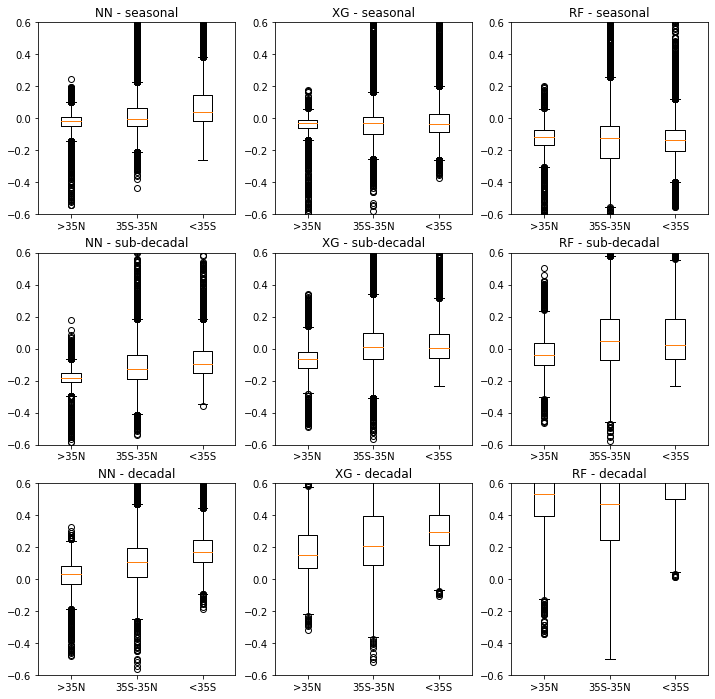

In [66]:
fig,ax = plt.subplots(3,3,figsize=(12,12))

approach_order = ["nn", "xg", "rf"]
data_sel = ["seasonal","resid","decadal"]
data_labels = ["seasonal","sub-decadal","decadal"]
metric_sel = "amp_%error"
lab = 'Mean amplitude %error ($pCO_2$)'
box_labs = [">35N","35S-35N","<35S"]

for i in range(3):
    for j in range(3):
        map_sel = map_data[(approach_order[j],data_sel[i],metric_sel)]
        region_low = map_sel.values[:,map_sel.ylat.values < -35].ravel()
        region_mid = map_sel.values[:,(map_sel.ylat.values >= -35) & (map_sel.ylat.values <= 35)].ravel()
        region_high = map_sel.values[:,map_sel.ylat.values > 35].ravel()
        
        region_low = region_low[~np.isnan(region_low)]
        region_mid = region_mid[~np.isnan(region_mid)]
        region_high = region_high[~np.isnan(region_high)]
        ax[i,j].boxplot([region_high,region_mid,region_low], labels=box_labs)
        ax[i,j].set_title(f"{approach_order[j].upper()} - {data_labels[i]}")
        ax[i,j].set_ylim([-.6,.6])
        
# plt.savefig("boxplots_amp_error_by_region.png")

In [67]:
approach_order = ["nn", "xg", "rf"]
data_sel = ["seasonal","resid","decadal"]
data_labels = ["seasonal","sub-decadal","decadal"]
metric_sel = "amp_%error"
lab = 'Mean amplitude %error ($pCO_2$)'
box_labs = [">35N","35S-35N","<35S"]

for i in range(3):
    for j in range(3):
        map_sel = map_data[(approach_order[j],data_sel[i],metric_sel)]
        region_low = map_sel.values[:,map_sel.ylat.values < -35].ravel()
        region_mid = map_sel.values[:,(map_sel.ylat.values >= -35) & (map_sel.ylat.values <= 35)].ravel()
        region_high = map_sel.values[:,map_sel.ylat.values > 35].ravel()
        
        region_low = region_low[~np.isnan(region_low)]
        region_mid = region_mid[~np.isnan(region_mid)]
        region_high = region_high[~np.isnan(region_high)]

        print(f"{approach_order[j]} / {data_labels[i]} - {box_labs[0]}: {region_high.mean():.0%}, {box_labs[1]}: {region_mid.mean():.0%}, {box_labs[2]}: {region_low.mean():.0%}")

nn / seasonal - >35N: -2%, 35S-35N: 2%, <35S: 12%
xg / seasonal - >35N: -5%, 35S-35N: -4%, <35S: 1%
rf / seasonal - >35N: -13%, 35S-35N: -13%, <35S: -13%
nn / sub-decadal - >35N: -18%, 35S-35N: -11%, <35S: -7%
xg / sub-decadal - >35N: -7%, 35S-35N: 3%, <35S: 3%
rf / sub-decadal - >35N: -3%, 35S-35N: 7%, <35S: 7%
nn / decadal - >35N: 2%, 35S-35N: 11%, <35S: 18%
xg / decadal - >35N: 17%, 35S-35N: 27%, <35S: 34%
rf / decadal - >35N: 57%, 35S-35N: 55%, <35S: 67%


In [68]:
print(region_low.shape)
print(region_mid.shape)
print(region_high.shape)

(12147,)
(16706,)
(4168,)


### Mean of metrics by region

In [69]:
data_sel = ["raw"]
data_labels = ["raw"]
metric_sel = "mae"
box_labs = [">35N","35S-35N","<35S"]

for i in range(1):
    for j in range(3):
        map_sel = map_data[(approach_order[j],data_sel[i],metric_sel)]
        region_low = map_sel.values[:,map_sel.ylat.values < -35].ravel()
        region_mid = map_sel.values[:,(map_sel.ylat.values >= -35) & (map_sel.ylat.values <= 35)].ravel()
        region_high = map_sel.values[:,map_sel.ylat.values > 35].ravel()
        
        region_low = region_low[~np.isnan(region_low)]
        region_mid = region_mid[~np.isnan(region_mid)]
        region_high = region_high[~np.isnan(region_high)]

        print(f"{approaches[j]} / {data_labels[i]} - {box_labs[0]}: {region_high.mean():.2}, {box_labs[1]}: {region_mid.mean():.2}, {box_labs[2]}: {region_low.mean():.2}")

nn / raw - >35N: 5.0, 35S-35N: 4.5, <35S: 4.7
xg / raw - >35N: 4.1, 35S-35N: 3.1, <35S: 3.5
rf / raw - >35N: 5.5, 35S-35N: 5.1, <35S: 4.8


### Number of data points dropped by 816 rule in CanESM2 model

In [71]:
data_dropped = {}
for ens, mems_list in mems_dict.items():
    for member in mems_list:
        data_dir = f"{data_output_dir}/{ens}/member_{member}"
        fname = f"data_clean_2D_mon_{ens}_{member}_1x1_198201-201701.pkl"
        file_path = f"{data_dir}/{fname}"
        df = pd.read_pickle(file_path)
        N_0 = ((~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)) & (df[target_sel] < 816).to_numpy().ravel()).sum()
        N_1 = ((~df[features_sel+target_sel+['net_mask']].isna().any(axis=1))).sum()
        data_dropped[(ens,member)] = {"N":N_1 - N_0}

In [73]:
data_dropped_df = pd.DataFrame.from_dict(data_dropped, orient="index")
data_dropped_df.rename_axis(index=["model","member"], inplace=True)

In [75]:
data_dropped_df.groupby("model").mean()

,N
model,
CESM,14.20
CanESM2,11295.84
GFDL,0.00
MPI,104.80


In [77]:
mean_val = data_dropped_df.groupby("model").mean().loc["CanESM2"].values[0]
print(f"Average number of data points dropped: {mean_val}")
print(f"Percentage of total: {mean_val/N_1}")

Average number of data points dropped: 11295.84
Percentage of total: 0.0008083566483409848


### Stdev of timescale correlation map - approach granularity

corr_std for ['seasonal', 'resid', 'decadal'] data by ML approach


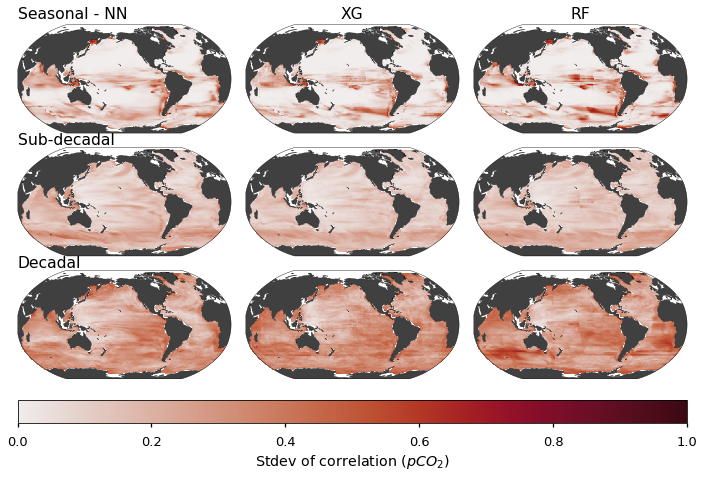

In [78]:
data_sel = ["seasonal","resid","decadal"]
metric_sel = "corr_std"
vrange = [0, 1, .01]
fig_shape = (3,len(data_sel))
cmap = cm.cm.amp
lab = 'Stdev of correlation ($pCO_2$)'

print(f"{metric_sel} for {data_sel} data by ML approach")      
      
with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(12,12))
    dia = SpatialMap(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    
    for i in range(fig_shape[0]*fig_shape[1]):
        map_sel = map_data[(approaches[i % 3],data_sel[i // 3],metric_sel)]
        sub = dia.add_plot(lat = map_sel['ylat'], 
                           lon = map_sel['xlon'], 
                           data = map_sel.T, 
                           vrange=vrange[0:2], 
                           cmap=cmap, 
                           ax=i)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col, lab)
    
    dia.set_title("Seasonal - NN", 0, loc="left")
    dia.set_title("XG", 1, loc="center")
    dia.set_title("RF", 2, loc="center")
    dia.set_title("Sub-decadal", 3, loc="left", pad=3)
    dia.set_title("Decadal", 6, loc="left", pad=3)

### Global mean time series examples

In [79]:
date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2017-01-31T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [80]:
ens = "CESM"
member = "002"

approach = "nn"
recon_output_dir = "/local/data/artemis/workspace/jfs2167/recon_eval/models/reconstructions"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
run = nn_val_df.query("model == @ens and member == @member and sel_min_bias_mse == 1").index.values[0][2]
recon_fname = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_{run}_1x1_198201-201701.nc"
DS_recon_nn = xr.load_dataset(recon_fname)

approach = "xg"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
recon_fname = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
DS_recon_xg = xr.load_dataset(recon_fname)

approach = "rf"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
recon_fname = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
DS_recon_rf = xr.load_dataset(recon_fname)

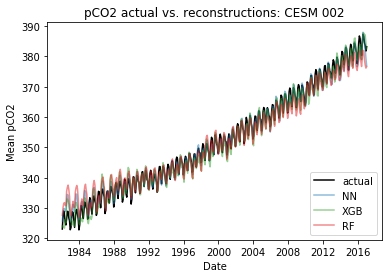

In [87]:
fig, ax = plt.subplots(1,1)
mask = ~np.isnan(DS_recon_nn["net_mask"])
ax.plot(dates, DS_recon_nn["pCO2"].where(mask).mean(["xlon","ylat"], skipna=True), c="black")

alph=0.5
ax.plot(dates,DS_recon_nn["pCO2_recon"].mean(["xlon","ylat"], skipna=True), c=approaches_colors[0], alpha=alph)
ax.plot(dates,DS_recon_xg["pCO2_recon"].mean(["xlon","ylat"], skipna=True), c=approaches_colors[1], alpha=alph)
ax.plot(dates,DS_recon_rf["pCO2_recon"].mean(["xlon","ylat"], skipna=True), c=approaches_colors[2], alpha=alph)

ax.legend(["actual","NN", "XGB", "RF"], loc="lower right")
ax.set_xlabel("Date")
ax.set_ylabel("Mean pCO2")
ax.set_title(f"pCO2 actual vs. reconstructions: {ens} {member}");

# plt.savefig(f'example_global_ts_{ens}_{member}.png', bbox_inches = "tight")

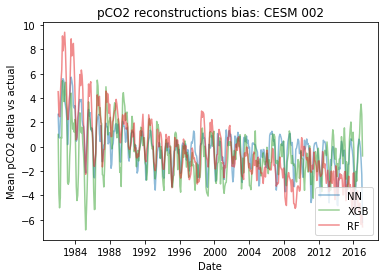

In [89]:
fig, ax = plt.subplots(1,1)
mask = ~np.isnan(DS_recon_nn["net_mask"])
avg_ts = DS_recon_nn["pCO2"].where(mask).mean(["xlon","ylat"], skipna=True)

alph=0.5
ax.plot(dates,DS_recon_nn["pCO2_recon"].mean(["xlon","ylat"], skipna=True)-avg_ts, c=approaches_colors[0], alpha=alph)
ax.plot(dates,DS_recon_xg["pCO2_recon"].mean(["xlon","ylat"], skipna=True)-avg_ts, c=approaches_colors[1], alpha=alph)
ax.plot(dates,DS_recon_rf["pCO2_recon"].mean(["xlon","ylat"], skipna=True)-avg_ts, c=approaches_colors[2], alpha=alph)

ax.legend(["NN", "XGB", "RF"], loc="lower right")
ax.set_xlabel("Date")
ax.set_ylabel("Mean pCO2 delta vs actual")
ax.set_title(f"pCO2 reconstructions bias: {ens} {member}");

# plt.savefig(f'example_bias_ts_{ens}_{member}.png', bbox_inches = "tight")

In [90]:
ens = "CanESM2"
member = "r3r6"

approach = "nn"
recon_output_dir = "/local/data/artemis/workspace/jfs2167/recon_eval/models/reconstructions"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
run = nn_val_df.query("model == @ens and member == @member and sel_min_bias_mse == 1").index.values[0][2]
recon_fname = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_{run}_1x1_198201-201701.nc"
DS_recon_nn = xr.load_dataset(recon_fname)

approach = "xg"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
recon_fname = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
DS_recon_xg = xr.load_dataset(recon_fname)

approach = "rf"
recon_dir = f"{recon_output_dir}/{approach}/{ens}/member_{member}"
recon_fname = f"{recon_dir}/{approach}_recon_pC02_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
DS_recon_rf = xr.load_dataset(recon_fname)

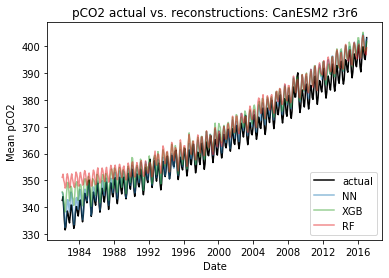

In [91]:
fig, ax = plt.subplots(1,1)
mask = ~np.isnan(DS_recon_nn["net_mask"])
ax.plot(dates,DS_recon_nn["pCO2"].where(mask).mean(["xlon","ylat"], skipna=True), c="black")

alph=0.5
ax.plot(dates,DS_recon_nn["pCO2_recon"].mean(["xlon","ylat"], skipna=True), c=approaches_colors[0], alpha=alph)
ax.plot(dates,DS_recon_xg["pCO2_recon"].mean(["xlon","ylat"], skipna=True), c=approaches_colors[1], alpha=alph)
ax.plot(dates,DS_recon_rf["pCO2_recon"].mean(["xlon","ylat"], skipna=True), c=approaches_colors[2], alpha=alph)

ax.legend(["actual","NN", "XGB", "RF"], loc="lower right")
ax.set_xlabel("Date")
ax.set_ylabel("Mean pCO2")
ax.set_title(f"pCO2 actual vs. reconstructions: {ens} {member}");

# plt.savefig(f'example_global_ts_{ens}_{member}.png', bbox_inches = "tight")

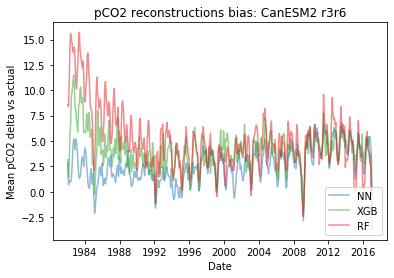

In [92]:
fig, ax = plt.subplots(1,1)
mask = ~np.isnan(DS_recon_nn["net_mask"])
avg_ts = DS_recon_nn["pCO2"].where(mask).mean(["xlon","ylat"], skipna=True)

alph=0.5
ax.plot(dates,DS_recon_nn["pCO2_recon"].mean(["xlon","ylat"], skipna=True)-avg_ts, c=approaches_colors[0], alpha=alph)
ax.plot(dates,DS_recon_xg["pCO2_recon"].mean(["xlon","ylat"], skipna=True)-avg_ts, c=approaches_colors[1], alpha=alph)
ax.plot(dates,DS_recon_rf["pCO2_recon"].mean(["xlon","ylat"], skipna=True)-avg_ts, c=approaches_colors[2], alpha=alph)

ax.legend(["NN", "XGB", "RF"], loc="lower right")
ax.set_xlabel("Date")
ax.set_ylabel("Mean pCO2 delta vs actual")
ax.set_title(f"pCO2 reconstructions bias: {ens} {member}");

# plt.savefig(f'example_bias_ts_{ens}_{member}.png', bbox_inches = "tight")